In [456]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

import sys
sys.path.insert(0,'/home/henning/git_repos/ummon3/examples')

import load_mnist

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

<Figure size 1080x540 with 0 Axes>

In [457]:
# read MNIST data set and scale it
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x0 = (1.0/255.0)*X0.astype('float64')
x1 = (1.0/255.0)*X1.astype('float64')
x2 = (1.0/255.0)*Xv.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = yv.astype('float64')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


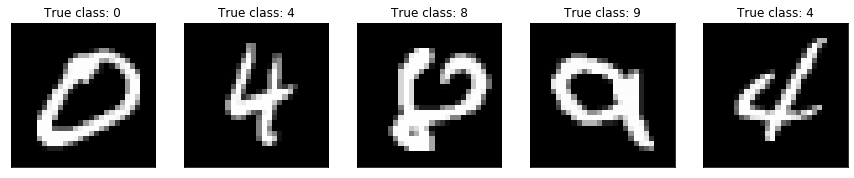

In [458]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

subsample = np.random.permutation(x0.shape[0])[:5]
images = x0[subsample]
labels = ['True class: %d' % np.argmax(l) for l in y0[subsample]]
plot_gallery(images, labels, shape=(28, 28))

Globale Arrays und Variablen des Netzwerkes:

In [459]:
# Netzwerkparameter
mbs =  32                    # Größe der Minibatches
eta = 0.01                   # Lernrate
no_hidden = 256              # Anzahl versteckter Neuronen
epochs = 15000               # Anzahl Epochen
sizes = [784, no_hidden, 10] # dreischichtiges MPL mit 784 Eingangs-, no_hidden versteckten, 10 Ausgangsneuronen
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[1].shape)

(10, 256)


Einige Hilfsfunktionen:

In [460]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [461]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [462]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    
    
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        t = np.dot(weights[-l+1].transpose(), delta)
        delta = t * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte
        
    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [463]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [464]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        c = np.argmax(y)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        cpred = np.argmax(ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct

Stochastischer Gradientenabstieg:

In [465]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    accuracys = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        accuracys[j] = evaluate(x2, y2)
        improvement = (accuracys[j] - accuracys[max(j - 1, 0)])
        improvement_percent = (improvement / accuracys[max(j - 1, 0)]) * 100
        print("Epoch {}: {} / {}, improvement: {:.2f}% / {}".format(j, accuracys[j], len(x2), improvement_percent, improvement))
    
    return accuracys

Training:

In [466]:
start = time.time()
accuracys = SGD(x0, y0, epochs, mbs, eta, x2, y2)
stop = time.time()
print("Elapsed time: {}".format(stop - start))

Epoch 0: 1029.0 / 10000, improvement: 0.00% / 0.0
Epoch 1: 1549.0 / 10000, improvement: 50.53% / 520.0
Epoch 2: 1646.0 / 10000, improvement: 6.26% / 97.0
Epoch 3: 1725.0 / 10000, improvement: 4.80% / 79.0
Epoch 4: 1794.0 / 10000, improvement: 4.00% / 69.0
Epoch 5: 1867.0 / 10000, improvement: 4.07% / 73.0
Epoch 6: 1921.0 / 10000, improvement: 2.89% / 54.0
Epoch 7: 1962.0 / 10000, improvement: 2.13% / 41.0
Epoch 8: 1994.0 / 10000, improvement: 1.63% / 32.0
Epoch 9: 2025.0 / 10000, improvement: 1.55% / 31.0
Epoch 10: 2071.0 / 10000, improvement: 2.27% / 46.0
Epoch 11: 2114.0 / 10000, improvement: 2.08% / 43.0
Epoch 12: 2148.0 / 10000, improvement: 1.61% / 34.0
Epoch 13: 2187.0 / 10000, improvement: 1.82% / 39.0
Epoch 14: 2232.0 / 10000, improvement: 2.06% / 45.0
Epoch 15: 2266.0 / 10000, improvement: 1.52% / 34.0
Epoch 16: 2298.0 / 10000, improvement: 1.41% / 32.0
Epoch 17: 2330.0 / 10000, improvement: 1.39% / 32.0
Epoch 18: 2356.0 / 10000, improvement: 1.12% / 26.0
Epoch 19: 2389.0 / 10

Epoch 158: 4960.0 / 10000, improvement: 0.12% / 6.0
Epoch 159: 4962.0 / 10000, improvement: 0.04% / 2.0
Epoch 160: 4967.0 / 10000, improvement: 0.10% / 5.0
Epoch 161: 4974.0 / 10000, improvement: 0.14% / 7.0
Epoch 162: 4977.0 / 10000, improvement: 0.06% / 3.0
Epoch 163: 4980.0 / 10000, improvement: 0.06% / 3.0
Epoch 164: 4981.0 / 10000, improvement: 0.02% / 1.0
Epoch 165: 4986.0 / 10000, improvement: 0.10% / 5.0
Epoch 166: 4989.0 / 10000, improvement: 0.06% / 3.0
Epoch 167: 4994.0 / 10000, improvement: 0.10% / 5.0
Epoch 168: 4998.0 / 10000, improvement: 0.08% / 4.0
Epoch 169: 5001.0 / 10000, improvement: 0.06% / 3.0
Epoch 170: 5009.0 / 10000, improvement: 0.16% / 8.0
Epoch 171: 5018.0 / 10000, improvement: 0.18% / 9.0
Epoch 172: 5026.0 / 10000, improvement: 0.16% / 8.0
Epoch 173: 5032.0 / 10000, improvement: 0.12% / 6.0
Epoch 174: 5038.0 / 10000, improvement: 0.12% / 6.0
Epoch 175: 5040.0 / 10000, improvement: 0.04% / 2.0
Epoch 176: 5050.0 / 10000, improvement: 0.20% / 10.0
Epoch 177: 

Epoch 315: 6575.0 / 10000, improvement: 0.02% / 1.0
Epoch 316: 6576.0 / 10000, improvement: 0.02% / 1.0
Epoch 317: 6577.0 / 10000, improvement: 0.02% / 1.0
Epoch 318: 6576.0 / 10000, improvement: -0.02% / -1.0
Epoch 319: 6579.0 / 10000, improvement: 0.05% / 3.0
Epoch 320: 6581.0 / 10000, improvement: 0.03% / 2.0
Epoch 321: 6580.0 / 10000, improvement: -0.02% / -1.0
Epoch 322: 6582.0 / 10000, improvement: 0.03% / 2.0
Epoch 323: 6580.0 / 10000, improvement: -0.03% / -2.0
Epoch 324: 6580.0 / 10000, improvement: 0.00% / 0.0
Epoch 325: 6581.0 / 10000, improvement: 0.02% / 1.0
Epoch 326: 6581.0 / 10000, improvement: 0.00% / 0.0
Epoch 327: 6581.0 / 10000, improvement: 0.00% / 0.0
Epoch 328: 6583.0 / 10000, improvement: 0.03% / 2.0
Epoch 329: 6582.0 / 10000, improvement: -0.02% / -1.0
Epoch 330: 6584.0 / 10000, improvement: 0.03% / 2.0
Epoch 331: 6584.0 / 10000, improvement: 0.00% / 0.0
Epoch 332: 6584.0 / 10000, improvement: 0.00% / 0.0
Epoch 333: 6584.0 / 10000, improvement: 0.00% / 0.0
Epoc

Epoch 472: 6658.0 / 10000, improvement: 0.03% / 2.0
Epoch 473: 6656.0 / 10000, improvement: -0.03% / -2.0
Epoch 474: 6658.0 / 10000, improvement: 0.03% / 2.0
Epoch 475: 6659.0 / 10000, improvement: 0.02% / 1.0
Epoch 476: 6659.0 / 10000, improvement: 0.00% / 0.0
Epoch 477: 6659.0 / 10000, improvement: 0.00% / 0.0
Epoch 478: 6659.0 / 10000, improvement: 0.00% / 0.0
Epoch 479: 6660.0 / 10000, improvement: 0.02% / 1.0
Epoch 480: 6661.0 / 10000, improvement: 0.02% / 1.0
Epoch 481: 6661.0 / 10000, improvement: 0.00% / 0.0
Epoch 482: 6662.0 / 10000, improvement: 0.02% / 1.0
Epoch 483: 6660.0 / 10000, improvement: -0.03% / -2.0
Epoch 484: 6662.0 / 10000, improvement: 0.03% / 2.0
Epoch 485: 6663.0 / 10000, improvement: 0.02% / 1.0
Epoch 486: 6663.0 / 10000, improvement: 0.00% / 0.0
Epoch 487: 6663.0 / 10000, improvement: 0.00% / 0.0
Epoch 488: 6664.0 / 10000, improvement: 0.02% / 1.0
Epoch 489: 6666.0 / 10000, improvement: 0.03% / 2.0
Epoch 490: 6666.0 / 10000, improvement: 0.00% / 0.0
Epoch 49

Epoch 629: 6715.0 / 10000, improvement: -0.01% / -1.0
Epoch 630: 6716.0 / 10000, improvement: 0.01% / 1.0
Epoch 631: 6716.0 / 10000, improvement: 0.00% / 0.0
Epoch 632: 6718.0 / 10000, improvement: 0.03% / 2.0
Epoch 633: 6715.0 / 10000, improvement: -0.04% / -3.0
Epoch 634: 6716.0 / 10000, improvement: 0.01% / 1.0
Epoch 635: 6718.0 / 10000, improvement: 0.03% / 2.0
Epoch 636: 6716.0 / 10000, improvement: -0.03% / -2.0
Epoch 637: 6717.0 / 10000, improvement: 0.01% / 1.0
Epoch 638: 6716.0 / 10000, improvement: -0.01% / -1.0
Epoch 639: 6719.0 / 10000, improvement: 0.04% / 3.0
Epoch 640: 6719.0 / 10000, improvement: 0.00% / 0.0
Epoch 641: 6719.0 / 10000, improvement: 0.00% / 0.0
Epoch 642: 6721.0 / 10000, improvement: 0.03% / 2.0
Epoch 643: 6721.0 / 10000, improvement: 0.00% / 0.0
Epoch 644: 6720.0 / 10000, improvement: -0.01% / -1.0
Epoch 645: 6721.0 / 10000, improvement: 0.01% / 1.0
Epoch 646: 6721.0 / 10000, improvement: 0.00% / 0.0
Epoch 647: 6720.0 / 10000, improvement: -0.01% / -1.0


Epoch 786: 6735.0 / 10000, improvement: 0.01% / 1.0
Epoch 787: 6735.0 / 10000, improvement: 0.00% / 0.0
Epoch 788: 6737.0 / 10000, improvement: 0.03% / 2.0
Epoch 789: 6736.0 / 10000, improvement: -0.01% / -1.0
Epoch 790: 6736.0 / 10000, improvement: 0.00% / 0.0
Epoch 791: 6737.0 / 10000, improvement: 0.01% / 1.0
Epoch 792: 6737.0 / 10000, improvement: 0.00% / 0.0
Epoch 793: 6736.0 / 10000, improvement: -0.01% / -1.0
Epoch 794: 6737.0 / 10000, improvement: 0.01% / 1.0
Epoch 795: 6737.0 / 10000, improvement: 0.00% / 0.0
Epoch 796: 6738.0 / 10000, improvement: 0.01% / 1.0
Epoch 797: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 798: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 799: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 800: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 801: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 802: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 803: 6738.0 / 10000, improvement: 0.00% / 0.0
Epoch 804: 6739.0 / 10000, improvement: 0.01% / 1.0
Epoch 80

Epoch 943: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 944: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 945: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 946: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 947: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 948: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 949: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 950: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 951: 6758.0 / 10000, improvement: 0.01% / 1.0
Epoch 952: 6757.0 / 10000, improvement: -0.01% / -1.0
Epoch 953: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 954: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 955: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 956: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 957: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 958: 6757.0 / 10000, improvement: 0.00% / 0.0
Epoch 959: 6756.0 / 10000, improvement: -0.01% / -1.0
Epoch 960: 6758.0 / 10000, improvement: 0.03% / 2.0
Epoch 961: 6755.0 / 10000, improvement: -0.04% / -3.0
Epoch 

Epoch 1098: 6767.0 / 10000, improvement: 0.00% / 0.0
Epoch 1099: 6767.0 / 10000, improvement: 0.00% / 0.0
Epoch 1100: 6766.0 / 10000, improvement: -0.01% / -1.0
Epoch 1101: 6767.0 / 10000, improvement: 0.01% / 1.0
Epoch 1102: 6767.0 / 10000, improvement: 0.00% / 0.0
Epoch 1103: 6765.0 / 10000, improvement: -0.03% / -2.0
Epoch 1104: 6766.0 / 10000, improvement: 0.01% / 1.0
Epoch 1105: 6767.0 / 10000, improvement: 0.01% / 1.0
Epoch 1106: 6765.0 / 10000, improvement: -0.03% / -2.0
Epoch 1107: 6765.0 / 10000, improvement: 0.00% / 0.0
Epoch 1108: 6767.0 / 10000, improvement: 0.03% / 2.0
Epoch 1109: 6765.0 / 10000, improvement: -0.03% / -2.0
Epoch 1110: 6766.0 / 10000, improvement: 0.01% / 1.0
Epoch 1111: 6763.0 / 10000, improvement: -0.04% / -3.0
Epoch 1112: 6766.0 / 10000, improvement: 0.04% / 3.0
Epoch 1113: 6765.0 / 10000, improvement: -0.01% / -1.0
Epoch 1114: 6765.0 / 10000, improvement: 0.00% / 0.0
Epoch 1115: 6765.0 / 10000, improvement: 0.00% / 0.0
Epoch 1116: 6766.0 / 10000, improv

Epoch 1251: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1252: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1253: 6772.0 / 10000, improvement: -0.01% / -1.0
Epoch 1254: 6773.0 / 10000, improvement: 0.01% / 1.0
Epoch 1255: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1256: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1257: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1258: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1259: 6772.0 / 10000, improvement: -0.01% / -1.0
Epoch 1260: 6773.0 / 10000, improvement: 0.01% / 1.0
Epoch 1261: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1262: 6773.0 / 10000, improvement: 0.00% / 0.0
Epoch 1263: 6772.0 / 10000, improvement: -0.01% / -1.0
Epoch 1264: 6771.0 / 10000, improvement: -0.01% / -1.0
Epoch 1265: 6772.0 / 10000, improvement: 0.01% / 1.0
Epoch 1266: 6774.0 / 10000, improvement: 0.03% / 2.0
Epoch 1267: 6774.0 / 10000, improvement: 0.00% / 0.0
Epoch 1268: 6774.0 / 10000, improvement: 0.00% / 0.0
Epoch 1269: 6774.0 / 10000, improvemen

Epoch 1404: 6781.0 / 10000, improvement: 0.00% / 0.0
Epoch 1405: 6781.0 / 10000, improvement: 0.00% / 0.0
Epoch 1406: 6781.0 / 10000, improvement: 0.00% / 0.0
Epoch 1407: 6781.0 / 10000, improvement: 0.00% / 0.0
Epoch 1408: 6780.0 / 10000, improvement: -0.01% / -1.0
Epoch 1409: 6782.0 / 10000, improvement: 0.03% / 2.0
Epoch 1410: 6781.0 / 10000, improvement: -0.01% / -1.0
Epoch 1411: 6781.0 / 10000, improvement: 0.00% / 0.0
Epoch 1412: 6782.0 / 10000, improvement: 0.01% / 1.0
Epoch 1413: 6783.0 / 10000, improvement: 0.01% / 1.0
Epoch 1414: 6784.0 / 10000, improvement: 0.01% / 1.0
Epoch 1415: 6784.0 / 10000, improvement: 0.00% / 0.0
Epoch 1416: 6783.0 / 10000, improvement: -0.01% / -1.0
Epoch 1417: 6784.0 / 10000, improvement: 0.01% / 1.0
Epoch 1418: 6781.0 / 10000, improvement: -0.04% / -3.0
Epoch 1419: 6782.0 / 10000, improvement: 0.01% / 1.0
Epoch 1420: 6781.0 / 10000, improvement: -0.01% / -1.0
Epoch 1421: 6784.0 / 10000, improvement: 0.04% / 3.0
Epoch 1422: 6783.0 / 10000, improvem

Epoch 1558: 6792.0 / 10000, improvement: 0.00% / 0.0
Epoch 1559: 6793.0 / 10000, improvement: 0.01% / 1.0
Epoch 1560: 6792.0 / 10000, improvement: -0.01% / -1.0
Epoch 1561: 6794.0 / 10000, improvement: 0.03% / 2.0
Epoch 1562: 6792.0 / 10000, improvement: -0.03% / -2.0
Epoch 1563: 6793.0 / 10000, improvement: 0.01% / 1.0
Epoch 1564: 6792.0 / 10000, improvement: -0.01% / -1.0
Epoch 1565: 6793.0 / 10000, improvement: 0.01% / 1.0
Epoch 1566: 6793.0 / 10000, improvement: 0.00% / 0.0
Epoch 1567: 6793.0 / 10000, improvement: 0.00% / 0.0
Epoch 1568: 6793.0 / 10000, improvement: 0.00% / 0.0
Epoch 1569: 6793.0 / 10000, improvement: 0.00% / 0.0
Epoch 1570: 6792.0 / 10000, improvement: -0.01% / -1.0
Epoch 1571: 6791.0 / 10000, improvement: -0.01% / -1.0
Epoch 1572: 6793.0 / 10000, improvement: 0.03% / 2.0
Epoch 1573: 6792.0 / 10000, improvement: -0.01% / -1.0
Epoch 1574: 6792.0 / 10000, improvement: 0.00% / 0.0
Epoch 1575: 6792.0 / 10000, improvement: 0.00% / 0.0
Epoch 1576: 6793.0 / 10000, improv

Epoch 1712: 6801.0 / 10000, improvement: -0.01% / -1.0
Epoch 1713: 6801.0 / 10000, improvement: 0.00% / 0.0
Epoch 1714: 6802.0 / 10000, improvement: 0.01% / 1.0
Epoch 1715: 6802.0 / 10000, improvement: 0.00% / 0.0
Epoch 1716: 6802.0 / 10000, improvement: 0.00% / 0.0
Epoch 1717: 6804.0 / 10000, improvement: 0.03% / 2.0
Epoch 1718: 6804.0 / 10000, improvement: 0.00% / 0.0
Epoch 1719: 6802.0 / 10000, improvement: -0.03% / -2.0
Epoch 1720: 6803.0 / 10000, improvement: 0.01% / 1.0
Epoch 1721: 6804.0 / 10000, improvement: 0.01% / 1.0
Epoch 1722: 6803.0 / 10000, improvement: -0.01% / -1.0
Epoch 1723: 6804.0 / 10000, improvement: 0.01% / 1.0
Epoch 1724: 6805.0 / 10000, improvement: 0.01% / 1.0
Epoch 1725: 6804.0 / 10000, improvement: -0.01% / -1.0
Epoch 1726: 6803.0 / 10000, improvement: -0.01% / -1.0
Epoch 1727: 6804.0 / 10000, improvement: 0.01% / 1.0
Epoch 1728: 6805.0 / 10000, improvement: 0.01% / 1.0
Epoch 1729: 6805.0 / 10000, improvement: 0.00% / 0.0
Epoch 1730: 6803.0 / 10000, improvem

Epoch 1866: 6810.0 / 10000, improvement: -0.01% / -1.0
Epoch 1867: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1868: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1869: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1870: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1871: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1872: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1873: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1874: 6811.0 / 10000, improvement: 0.01% / 1.0
Epoch 1875: 6811.0 / 10000, improvement: 0.00% / 0.0
Epoch 1876: 6810.0 / 10000, improvement: -0.01% / -1.0
Epoch 1877: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1878: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1879: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1880: 6810.0 / 10000, improvement: 0.00% / 0.0
Epoch 1881: 6812.0 / 10000, improvement: 0.03% / 2.0
Epoch 1882: 6812.0 / 10000, improvement: 0.00% / 0.0
Epoch 1883: 6811.0 / 10000, improvement: -0.01% / -1.0
Epoch 1884: 6811.0 / 10000, improvement:

Epoch 2020: 6817.0 / 10000, improvement: 0.03% / 2.0
Epoch 2021: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2022: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2023: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2024: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2025: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2026: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2027: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2028: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2029: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2030: 6817.0 / 10000, improvement: 0.00% / 0.0
Epoch 2031: 6816.0 / 10000, improvement: -0.01% / -1.0
Epoch 2032: 6817.0 / 10000, improvement: 0.01% / 1.0
Epoch 2033: 6816.0 / 10000, improvement: -0.01% / -1.0
Epoch 2034: 6816.0 / 10000, improvement: 0.00% / 0.0
Epoch 2035: 6816.0 / 10000, improvement: 0.00% / 0.0
Epoch 2036: 6817.0 / 10000, improvement: 0.01% / 1.0
Epoch 2037: 6816.0 / 10000, improvement: -0.01% / -1.0
Epoch 2038: 6816.0 / 10000, improvement:

Epoch 2174: 6824.0 / 10000, improvement: 0.00% / 0.0
Epoch 2175: 6824.0 / 10000, improvement: 0.00% / 0.0
Epoch 2176: 6825.0 / 10000, improvement: 0.01% / 1.0
Epoch 2177: 6825.0 / 10000, improvement: 0.00% / 0.0
Epoch 2178: 6825.0 / 10000, improvement: 0.00% / 0.0
Epoch 2179: 6825.0 / 10000, improvement: 0.00% / 0.0
Epoch 2180: 6824.0 / 10000, improvement: -0.01% / -1.0
Epoch 2181: 6825.0 / 10000, improvement: 0.01% / 1.0
Epoch 2182: 6824.0 / 10000, improvement: -0.01% / -1.0
Epoch 2183: 6825.0 / 10000, improvement: 0.01% / 1.0
Epoch 2184: 6825.0 / 10000, improvement: 0.00% / 0.0
Epoch 2185: 6824.0 / 10000, improvement: -0.01% / -1.0
Epoch 2186: 6825.0 / 10000, improvement: 0.01% / 1.0
Epoch 2187: 6823.0 / 10000, improvement: -0.03% / -2.0
Epoch 2188: 6825.0 / 10000, improvement: 0.03% / 2.0
Epoch 2189: 6824.0 / 10000, improvement: -0.01% / -1.0
Epoch 2190: 6823.0 / 10000, improvement: -0.01% / -1.0
Epoch 2191: 6825.0 / 10000, improvement: 0.03% / 2.0
Epoch 2192: 6824.0 / 10000, improv

Epoch 2327: 6827.0 / 10000, improvement: -0.03% / -2.0
Epoch 2328: 6830.0 / 10000, improvement: 0.04% / 3.0
Epoch 2329: 6828.0 / 10000, improvement: -0.03% / -2.0
Epoch 2330: 6826.0 / 10000, improvement: -0.03% / -2.0
Epoch 2331: 6828.0 / 10000, improvement: 0.03% / 2.0
Epoch 2332: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2333: 6829.0 / 10000, improvement: 0.01% / 1.0
Epoch 2334: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2335: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2336: 6828.0 / 10000, improvement: -0.01% / -1.0
Epoch 2337: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2338: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2339: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2340: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2341: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2342: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2343: 6828.0 / 10000, improvement: 0.00% / 0.0
Epoch 2344: 6827.0 / 10000, improvement: -0.01% / -1.0
Epoch 2345: 6828.0 / 10000, improvem

Epoch 2480: 6830.0 / 10000, improvement: 0.00% / 0.0
Epoch 2481: 6829.0 / 10000, improvement: -0.01% / -1.0
Epoch 2482: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2483: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2484: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2485: 6830.0 / 10000, improvement: 0.01% / 1.0
Epoch 2486: 6829.0 / 10000, improvement: -0.01% / -1.0
Epoch 2487: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2488: 6830.0 / 10000, improvement: 0.01% / 1.0
Epoch 2489: 6830.0 / 10000, improvement: 0.00% / 0.0
Epoch 2490: 6830.0 / 10000, improvement: 0.00% / 0.0
Epoch 2491: 6829.0 / 10000, improvement: -0.01% / -1.0
Epoch 2492: 6830.0 / 10000, improvement: 0.01% / 1.0
Epoch 2493: 6829.0 / 10000, improvement: -0.01% / -1.0
Epoch 2494: 6829.0 / 10000, improvement: 0.00% / 0.0
Epoch 2495: 6828.0 / 10000, improvement: -0.01% / -1.0
Epoch 2496: 6829.0 / 10000, improvement: 0.01% / 1.0
Epoch 2497: 6830.0 / 10000, improvement: 0.01% / 1.0
Epoch 2498: 6829.0 / 10000, improvem

Epoch 2634: 6835.0 / 10000, improvement: 0.01% / 1.0
Epoch 2635: 6834.0 / 10000, improvement: -0.01% / -1.0
Epoch 2636: 6835.0 / 10000, improvement: 0.01% / 1.0
Epoch 2637: 6834.0 / 10000, improvement: -0.01% / -1.0
Epoch 2638: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2639: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2640: 6834.0 / 10000, improvement: 0.00% / 0.0
Epoch 2641: 6834.0 / 10000, improvement: 0.00% / 0.0
Epoch 2642: 6835.0 / 10000, improvement: 0.01% / 1.0
Epoch 2643: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2644: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2645: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2646: 6834.0 / 10000, improvement: -0.01% / -1.0
Epoch 2647: 6835.0 / 10000, improvement: 0.01% / 1.0
Epoch 2648: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2649: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2650: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2651: 6835.0 / 10000, improvement: 0.00% / 0.0
Epoch 2652: 6835.0 / 10000, improvemen

Epoch 2788: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2789: 6834.0 / 10000, improvement: 0.00% / 0.0
Epoch 2790: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2791: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2792: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2793: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2794: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2795: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2796: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2797: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2798: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2799: 6834.0 / 10000, improvement: 0.01% / 1.0
Epoch 2800: 6833.0 / 10000, improvement: -0.01% / -1.0
Epoch 2801: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2802: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2803: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2804: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2805: 6833.0 / 10000, improvement: 0.00% / 0.0
Epoch 2806: 6834.0 / 10000, improvem

Epoch 2942: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2943: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2944: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2945: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2946: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2947: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2948: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2949: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2950: 6841.0 / 10000, improvement: -0.01% / -1.0
Epoch 2951: 6841.0 / 10000, improvement: 0.00% / 0.0
Epoch 2952: 6842.0 / 10000, improvement: 0.01% / 1.0
Epoch 2953: 6841.0 / 10000, improvement: -0.01% / -1.0
Epoch 2954: 6842.0 / 10000, improvement: 0.01% / 1.0
Epoch 2955: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2956: 6841.0 / 10000, improvement: -0.01% / -1.0
Epoch 2957: 6842.0 / 10000, improvement: 0.01% / 1.0
Epoch 2958: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2959: 6842.0 / 10000, improvement: 0.00% / 0.0
Epoch 2960: 6842.0 / 10000, improvement:

Epoch 3097: 6845.0 / 10000, improvement: 0.01% / 1.0
Epoch 3098: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3099: 6844.0 / 10000, improvement: -0.01% / -1.0
Epoch 3100: 6844.0 / 10000, improvement: 0.00% / 0.0
Epoch 3101: 6845.0 / 10000, improvement: 0.01% / 1.0
Epoch 3102: 6844.0 / 10000, improvement: -0.01% / -1.0
Epoch 3103: 6844.0 / 10000, improvement: 0.00% / 0.0
Epoch 3104: 6845.0 / 10000, improvement: 0.01% / 1.0
Epoch 3105: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3106: 6844.0 / 10000, improvement: -0.01% / -1.0
Epoch 3107: 6846.0 / 10000, improvement: 0.03% / 2.0
Epoch 3108: 6845.0 / 10000, improvement: -0.01% / -1.0
Epoch 3109: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3110: 6846.0 / 10000, improvement: 0.01% / 1.0
Epoch 3111: 6845.0 / 10000, improvement: -0.01% / -1.0
Epoch 3112: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3113: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3114: 6845.0 / 10000, improvement: 0.00% / 0.0
Epoch 3115: 6845.0 / 10000, improvem

Epoch 3251: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3252: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3253: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3254: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3255: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3256: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3257: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3258: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3259: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3260: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3261: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3262: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3263: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3264: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3265: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3266: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3267: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3268: 6847.0 / 10000, improvement: 0.00% / 0.0
Epoch 3269: 6847.0 / 10000, improvement: 0.00%

Epoch 3406: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3407: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3408: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3409: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3410: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3411: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3412: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3413: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3414: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3415: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3416: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3417: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3418: 6850.0 / 10000, improvement: -0.01% / -1.0
Epoch 3419: 6851.0 / 10000, improvement: 0.01% / 1.0
Epoch 3420: 6851.0 / 10000, improvement: 0.00% / 0.0
Epoch 3421: 6850.0 / 10000, improvement: -0.01% / -1.0
Epoch 3422: 6852.0 / 10000, improvement: 0.03% / 2.0
Epoch 3423: 6851.0 / 10000, improvement: -0.01% / -1.0
Epoch 3424: 6852.0 / 10000, improvement:

Epoch 3560: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3561: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3562: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3563: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3564: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3565: 6857.0 / 10000, improvement: 0.01% / 1.0
Epoch 3566: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3567: 6856.0 / 10000, improvement: -0.01% / -1.0
Epoch 3568: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3569: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3570: 6856.0 / 10000, improvement: 0.00% / 0.0
Epoch 3571: 6857.0 / 10000, improvement: 0.01% / 1.0
Epoch 3572: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3573: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3574: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3575: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3576: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3577: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3578: 6857.0 / 10000, improvement: 0.0

Epoch 3714: 6858.0 / 10000, improvement: -0.01% / -1.0
Epoch 3715: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3716: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3717: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3718: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3719: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3720: 6859.0 / 10000, improvement: 0.01% / 1.0
Epoch 3721: 6858.0 / 10000, improvement: -0.01% / -1.0
Epoch 3722: 6859.0 / 10000, improvement: 0.01% / 1.0
Epoch 3723: 6858.0 / 10000, improvement: -0.01% / -1.0
Epoch 3724: 6857.0 / 10000, improvement: -0.01% / -1.0
Epoch 3725: 6858.0 / 10000, improvement: 0.01% / 1.0
Epoch 3726: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3727: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3728: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3729: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3730: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3731: 6858.0 / 10000, improvement: 0.00% / 0.0
Epoch 3732: 6858.0 / 10000, improvemen

Epoch 3868: 6856.0 / 10000, improvement: -0.01% / -1.0
Epoch 3869: 6857.0 / 10000, improvement: 0.01% / 1.0
Epoch 3870: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3871: 6856.0 / 10000, improvement: -0.01% / -1.0
Epoch 3872: 6857.0 / 10000, improvement: 0.01% / 1.0
Epoch 3873: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3874: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3875: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3876: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3877: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3878: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3879: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3880: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3881: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3882: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3883: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3884: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3885: 6857.0 / 10000, improvement: 0.00% / 0.0
Epoch 3886: 6857.0 / 10000, improvement: 0

Epoch 4022: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4023: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4024: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4025: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4026: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4027: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4028: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4029: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4030: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4031: 6861.0 / 10000, improvement: -0.01% / -1.0
Epoch 4032: 6862.0 / 10000, improvement: 0.01% / 1.0
Epoch 4033: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4034: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4035: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4036: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4037: 6861.0 / 10000, improvement: -0.01% / -1.0
Epoch 4038: 6862.0 / 10000, improvement: 0.01% / 1.0
Epoch 4039: 6861.0 / 10000, improvement: -0.01% / -1.0
Epoch 4040: 6862.0 / 10000, improvement:

Epoch 4176: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4177: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4178: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4179: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4180: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4181: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4182: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4183: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4184: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4185: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4186: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4187: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4188: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4189: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4190: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4191: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4192: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4193: 6864.0 / 10000, improvement: 0.00% / 0.0
Epoch 4194: 6864.0 / 10000, improvement: 0.00%

Epoch 4330: 6862.0 / 10000, improvement: -0.01% / -1.0
Epoch 4331: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4332: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4333: 6863.0 / 10000, improvement: 0.01% / 1.0
Epoch 4334: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4335: 6862.0 / 10000, improvement: -0.01% / -1.0
Epoch 4336: 6863.0 / 10000, improvement: 0.01% / 1.0
Epoch 4337: 6862.0 / 10000, improvement: -0.01% / -1.0
Epoch 4338: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4339: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4340: 6862.0 / 10000, improvement: 0.00% / 0.0
Epoch 4341: 6863.0 / 10000, improvement: 0.01% / 1.0
Epoch 4342: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4343: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4344: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4345: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4346: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4347: 6863.0 / 10000, improvement: 0.00% / 0.0
Epoch 4348: 6863.0 / 10000, improvement:

Epoch 4484: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4485: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4486: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4487: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4488: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4489: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4490: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4491: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4492: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4493: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4494: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4495: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4496: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4497: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4498: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4499: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4500: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4501: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4502: 6866.0 / 10000, improvement: 0.00%

Epoch 4639: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4640: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4641: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4642: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4643: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4644: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4645: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4646: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4647: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4648: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4649: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4650: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4651: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4652: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4653: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4654: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4655: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4656: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4657: 6865.0 / 10000, improvement: 0.00%

Epoch 4794: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4795: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4796: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4797: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4798: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4799: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4800: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4801: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4802: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4803: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4804: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4805: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4806: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4807: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4808: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4809: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4810: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4811: 6865.0 / 10000, improvement: 0.00% / 0.0
Epoch 4812: 6864.0 / 10000, improvement: -0.01

Epoch 4949: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4950: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4951: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4952: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4953: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4954: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4955: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4956: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4957: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4958: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4959: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4960: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4961: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4962: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4963: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4964: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4965: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4966: 6866.0 / 10000, improvement: 0.00% / 0.0
Epoch 4967: 6866.0 / 10000, improvement: 0.00%

Epoch 5104: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5105: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5106: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5107: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5108: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5109: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5110: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5111: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5112: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5113: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5114: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5115: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5116: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5117: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5118: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5119: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5120: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5121: 6868.0 / 10000, improvement: 0.00% / 0.0
Epoch 5122: 6868.0 / 10000, improvement: 0.00%

Epoch 5259: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5260: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5261: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5262: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5263: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5264: 6870.0 / 10000, improvement: 0.00% / 0.0
Epoch 5265: 6871.0 / 10000, improvement: 0.01% / 1.0
Epoch 5266: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5267: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5268: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5269: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5270: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5271: 6870.0 / 10000, improvement: -0.01% / -1.0
Epoch 5272: 6871.0 / 10000, improvement: 0.01% / 1.0
Epoch 5273: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5274: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5275: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5276: 6871.0 / 10000, improvement: 0.00% / 0.0
Epoch 5277: 6871.0 / 10000, improvement: 0.0

Epoch 5414: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5415: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5416: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5417: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5418: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5419: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5420: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5421: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5422: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5423: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5424: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5425: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5426: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5427: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5428: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5429: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5430: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5431: 6876.0 / 10000, improvement: 0.00% / 0.0
Epoch 5432: 6876.0 / 10000, improvement: 0.00%

Epoch 5569: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5570: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5571: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5572: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5573: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5574: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5575: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5576: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5577: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5578: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5579: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5580: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5581: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5582: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5583: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5584: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5585: 6879.0 / 10000, improvement: 0.00% / 0.0
Epoch 5586: 6880.0 / 10000, improvement: 0.01% / 1.0
Epoch 5587: 6879.0 / 10000, improvement: -0.01

Epoch 5724: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5725: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5726: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5727: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5728: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5729: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5730: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5731: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5732: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5733: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5734: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5735: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5736: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5737: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5738: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5739: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5740: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5741: 6883.0 / 10000, improvement: 0.00% / 0.0
Epoch 5742: 6883.0 / 10000, improvement: 0.00%

Epoch 5879: 6889.0 / 10000, improvement: 0.00% / 0.0
Epoch 5880: 6889.0 / 10000, improvement: 0.00% / 0.0
Epoch 5881: 6889.0 / 10000, improvement: 0.00% / 0.0
Epoch 5882: 6889.0 / 10000, improvement: 0.00% / 0.0
Epoch 5883: 6889.0 / 10000, improvement: 0.00% / 0.0
Epoch 5884: 6890.0 / 10000, improvement: 0.01% / 1.0
Epoch 5885: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5886: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5887: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5888: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5889: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5890: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5891: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5892: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5893: 6889.0 / 10000, improvement: -0.01% / -1.0
Epoch 5894: 6890.0 / 10000, improvement: 0.01% / 1.0
Epoch 5895: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5896: 6890.0 / 10000, improvement: 0.00% / 0.0
Epoch 5897: 6890.0 / 10000, improvement: 0.0

Epoch 6034: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6035: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6036: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6037: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6038: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6039: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6040: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6041: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6042: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6043: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6044: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6045: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6046: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6047: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6048: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6049: 6895.0 / 10000, improvement: 0.01% / 1.0
Epoch 6050: 6895.0 / 10000, improvement: 0.00% / 0.0
Epoch 6051: 6895.0 / 10000, improvement: 0.00% / 0.0
Epoch 6052: 6894.0 / 10000, improvement: -0.01

Epoch 6189: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6190: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6191: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6192: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6193: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6194: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6195: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6196: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6197: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6198: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6199: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6200: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6201: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6202: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6203: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6204: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6205: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6206: 6894.0 / 10000, improvement: 0.00% / 0.0
Epoch 6207: 6894.0 / 10000, improvement: 0.00%

Epoch 6344: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6345: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6346: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6347: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6348: 6898.0 / 10000, improvement: -0.01% / -1.0
Epoch 6349: 6898.0 / 10000, improvement: 0.00% / 0.0
Epoch 6350: 6899.0 / 10000, improvement: 0.01% / 1.0
Epoch 6351: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6352: 6898.0 / 10000, improvement: -0.01% / -1.0
Epoch 6353: 6898.0 / 10000, improvement: 0.00% / 0.0
Epoch 6354: 6898.0 / 10000, improvement: 0.00% / 0.0
Epoch 6355: 6898.0 / 10000, improvement: 0.00% / 0.0
Epoch 6356: 6898.0 / 10000, improvement: 0.00% / 0.0
Epoch 6357: 6899.0 / 10000, improvement: 0.01% / 1.0
Epoch 6358: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6359: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6360: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6361: 6899.0 / 10000, improvement: 0.00% / 0.0
Epoch 6362: 6899.0 / 10000, improvement: 0

Epoch 6499: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6500: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6501: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6502: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6503: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6504: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6505: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6506: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6507: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6508: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6509: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6510: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6511: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6512: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6513: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6514: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6515: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6516: 6902.0 / 10000, improvement: 0.00% / 0.0
Epoch 6517: 6902.0 / 10000, improvement: 0.00%

Epoch 6654: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6655: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6656: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6657: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6658: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6659: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6660: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6661: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6662: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6663: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6664: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6665: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6666: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6667: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6668: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6669: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6670: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6671: 6903.0 / 10000, improvement: 0.00% / 0.0
Epoch 6672: 6903.0 / 10000, improvement: 0.00%

Epoch 6809: 6918.0 / 10000, improvement: 0.00% / 0.0
Epoch 6810: 6918.0 / 10000, improvement: 0.00% / 0.0
Epoch 6811: 6917.0 / 10000, improvement: -0.01% / -1.0
Epoch 6812: 6918.0 / 10000, improvement: 0.01% / 1.0
Epoch 6813: 6917.0 / 10000, improvement: -0.01% / -1.0
Epoch 6814: 6918.0 / 10000, improvement: 0.01% / 1.0
Epoch 6815: 6918.0 / 10000, improvement: 0.00% / 0.0
Epoch 6816: 6918.0 / 10000, improvement: 0.00% / 0.0
Epoch 6817: 6917.0 / 10000, improvement: -0.01% / -1.0
Epoch 6818: 6917.0 / 10000, improvement: 0.00% / 0.0
Epoch 6819: 6918.0 / 10000, improvement: 0.01% / 1.0
Epoch 6820: 6918.0 / 10000, improvement: 0.00% / 0.0
Epoch 6821: 6917.0 / 10000, improvement: -0.01% / -1.0
Epoch 6822: 6917.0 / 10000, improvement: 0.00% / 0.0
Epoch 6823: 6917.0 / 10000, improvement: 0.00% / 0.0
Epoch 6824: 6917.0 / 10000, improvement: 0.00% / 0.0
Epoch 6825: 6917.0 / 10000, improvement: 0.00% / 0.0
Epoch 6826: 6918.0 / 10000, improvement: 0.01% / 1.0
Epoch 6827: 6918.0 / 10000, improvemen

Epoch 6964: 7050.0 / 10000, improvement: 0.06% / 4.0
Epoch 6965: 7056.0 / 10000, improvement: 0.09% / 6.0
Epoch 6966: 7062.0 / 10000, improvement: 0.09% / 6.0
Epoch 6967: 7067.0 / 10000, improvement: 0.07% / 5.0
Epoch 6968: 7073.0 / 10000, improvement: 0.08% / 6.0
Epoch 6969: 7079.0 / 10000, improvement: 0.08% / 6.0
Epoch 6970: 7087.0 / 10000, improvement: 0.11% / 8.0
Epoch 6971: 7092.0 / 10000, improvement: 0.07% / 5.0
Epoch 6972: 7104.0 / 10000, improvement: 0.17% / 12.0
Epoch 6973: 7114.0 / 10000, improvement: 0.14% / 10.0
Epoch 6974: 7126.0 / 10000, improvement: 0.17% / 12.0
Epoch 6975: 7133.0 / 10000, improvement: 0.10% / 7.0
Epoch 6976: 7143.0 / 10000, improvement: 0.14% / 10.0
Epoch 6977: 7155.0 / 10000, improvement: 0.17% / 12.0
Epoch 6978: 7169.0 / 10000, improvement: 0.20% / 14.0
Epoch 6979: 7177.0 / 10000, improvement: 0.11% / 8.0
Epoch 6980: 7194.0 / 10000, improvement: 0.24% / 17.0
Epoch 6981: 7205.0 / 10000, improvement: 0.15% / 11.0
Epoch 6982: 7216.0 / 10000, improvemen

Epoch 7118: 7549.0 / 10000, improvement: 0.00% / 0.0
Epoch 7119: 7550.0 / 10000, improvement: 0.01% / 1.0
Epoch 7120: 7553.0 / 10000, improvement: 0.04% / 3.0
Epoch 7121: 7554.0 / 10000, improvement: 0.01% / 1.0
Epoch 7122: 7554.0 / 10000, improvement: 0.00% / 0.0
Epoch 7123: 7555.0 / 10000, improvement: 0.01% / 1.0
Epoch 7124: 7555.0 / 10000, improvement: 0.00% / 0.0
Epoch 7125: 7557.0 / 10000, improvement: 0.03% / 2.0
Epoch 7126: 7557.0 / 10000, improvement: 0.00% / 0.0
Epoch 7127: 7557.0 / 10000, improvement: 0.00% / 0.0
Epoch 7128: 7559.0 / 10000, improvement: 0.03% / 2.0
Epoch 7129: 7560.0 / 10000, improvement: 0.01% / 1.0
Epoch 7130: 7561.0 / 10000, improvement: 0.01% / 1.0
Epoch 7131: 7562.0 / 10000, improvement: 0.01% / 1.0
Epoch 7132: 7563.0 / 10000, improvement: 0.01% / 1.0
Epoch 7133: 7565.0 / 10000, improvement: 0.03% / 2.0
Epoch 7134: 7565.0 / 10000, improvement: 0.00% / 0.0
Epoch 7135: 7567.0 / 10000, improvement: 0.03% / 2.0
Epoch 7136: 7569.0 / 10000, improvement: 0.03%

Epoch 7272: 7621.0 / 10000, improvement: 0.00% / 0.0
Epoch 7273: 7621.0 / 10000, improvement: 0.00% / 0.0
Epoch 7274: 7622.0 / 10000, improvement: 0.01% / 1.0
Epoch 7275: 7621.0 / 10000, improvement: -0.01% / -1.0
Epoch 7276: 7622.0 / 10000, improvement: 0.01% / 1.0
Epoch 7277: 7623.0 / 10000, improvement: 0.01% / 1.0
Epoch 7278: 7623.0 / 10000, improvement: 0.00% / 0.0
Epoch 7279: 7623.0 / 10000, improvement: 0.00% / 0.0
Epoch 7280: 7624.0 / 10000, improvement: 0.01% / 1.0
Epoch 7281: 7624.0 / 10000, improvement: 0.00% / 0.0
Epoch 7282: 7624.0 / 10000, improvement: 0.00% / 0.0
Epoch 7283: 7624.0 / 10000, improvement: 0.00% / 0.0
Epoch 7284: 7623.0 / 10000, improvement: -0.01% / -1.0
Epoch 7285: 7624.0 / 10000, improvement: 0.01% / 1.0
Epoch 7286: 7625.0 / 10000, improvement: 0.01% / 1.0
Epoch 7287: 7625.0 / 10000, improvement: 0.00% / 0.0
Epoch 7288: 7625.0 / 10000, improvement: 0.00% / 0.0
Epoch 7289: 7625.0 / 10000, improvement: 0.00% / 0.0
Epoch 7290: 7624.0 / 10000, improvement: -

Epoch 7426: 7652.0 / 10000, improvement: -0.01% / -1.0
Epoch 7427: 7653.0 / 10000, improvement: 0.01% / 1.0
Epoch 7428: 7653.0 / 10000, improvement: 0.00% / 0.0
Epoch 7429: 7653.0 / 10000, improvement: 0.00% / 0.0
Epoch 7430: 7652.0 / 10000, improvement: -0.01% / -1.0
Epoch 7431: 7653.0 / 10000, improvement: 0.01% / 1.0
Epoch 7432: 7652.0 / 10000, improvement: -0.01% / -1.0
Epoch 7433: 7653.0 / 10000, improvement: 0.01% / 1.0
Epoch 7434: 7654.0 / 10000, improvement: 0.01% / 1.0
Epoch 7435: 7654.0 / 10000, improvement: 0.00% / 0.0
Epoch 7436: 7654.0 / 10000, improvement: 0.00% / 0.0
Epoch 7437: 7655.0 / 10000, improvement: 0.01% / 1.0
Epoch 7438: 7653.0 / 10000, improvement: -0.03% / -2.0
Epoch 7439: 7655.0 / 10000, improvement: 0.03% / 2.0
Epoch 7440: 7655.0 / 10000, improvement: 0.00% / 0.0
Epoch 7441: 7655.0 / 10000, improvement: 0.00% / 0.0
Epoch 7442: 7655.0 / 10000, improvement: 0.00% / 0.0
Epoch 7443: 7656.0 / 10000, improvement: 0.01% / 1.0
Epoch 7444: 7654.0 / 10000, improvemen

Epoch 7580: 7670.0 / 10000, improvement: 0.00% / 0.0
Epoch 7581: 7669.0 / 10000, improvement: -0.01% / -1.0
Epoch 7582: 7670.0 / 10000, improvement: 0.01% / 1.0
Epoch 7583: 7670.0 / 10000, improvement: 0.00% / 0.0
Epoch 7584: 7670.0 / 10000, improvement: 0.00% / 0.0
Epoch 7585: 7670.0 / 10000, improvement: 0.00% / 0.0
Epoch 7586: 7669.0 / 10000, improvement: -0.01% / -1.0
Epoch 7587: 7671.0 / 10000, improvement: 0.03% / 2.0
Epoch 7588: 7670.0 / 10000, improvement: -0.01% / -1.0
Epoch 7589: 7669.0 / 10000, improvement: -0.01% / -1.0
Epoch 7590: 7670.0 / 10000, improvement: 0.01% / 1.0
Epoch 7591: 7671.0 / 10000, improvement: 0.01% / 1.0
Epoch 7592: 7671.0 / 10000, improvement: 0.00% / 0.0
Epoch 7593: 7671.0 / 10000, improvement: 0.00% / 0.0
Epoch 7594: 7669.0 / 10000, improvement: -0.03% / -2.0
Epoch 7595: 7670.0 / 10000, improvement: 0.01% / 1.0
Epoch 7596: 7670.0 / 10000, improvement: 0.00% / 0.0
Epoch 7597: 7669.0 / 10000, improvement: -0.01% / -1.0
Epoch 7598: 7670.0 / 10000, improv

Epoch 7734: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7735: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7736: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7737: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7738: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7739: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7740: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7741: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7742: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7743: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7744: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7745: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7746: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7747: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7748: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7749: 7679.0 / 10000, improvement: 0.00% / 0.0
Epoch 7750: 7680.0 / 10000, improvement: 0.01% / 1.0
Epoch 7751: 7680.0 / 10000, improvement: 0.00% / 0.0
Epoch 7752: 7679.0 / 10000, improvement: -0.01

Epoch 7888: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7889: 7685.0 / 10000, improvement: 0.01% / 1.0
Epoch 7890: 7684.0 / 10000, improvement: -0.01% / -1.0
Epoch 7891: 7685.0 / 10000, improvement: 0.01% / 1.0
Epoch 7892: 7684.0 / 10000, improvement: -0.01% / -1.0
Epoch 7893: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7894: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7895: 7685.0 / 10000, improvement: 0.01% / 1.0
Epoch 7896: 7684.0 / 10000, improvement: -0.01% / -1.0
Epoch 7897: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7898: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7899: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7900: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7901: 7684.0 / 10000, improvement: 0.00% / 0.0
Epoch 7902: 7685.0 / 10000, improvement: 0.01% / 1.0
Epoch 7903: 7685.0 / 10000, improvement: 0.00% / 0.0
Epoch 7904: 7685.0 / 10000, improvement: 0.00% / 0.0
Epoch 7905: 7685.0 / 10000, improvement: 0.00% / 0.0
Epoch 7906: 7685.0 / 10000, improvement:

Epoch 8042: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8043: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8044: 7690.0 / 10000, improvement: -0.01% / -1.0
Epoch 8045: 7690.0 / 10000, improvement: 0.00% / 0.0
Epoch 8046: 7690.0 / 10000, improvement: 0.00% / 0.0
Epoch 8047: 7691.0 / 10000, improvement: 0.01% / 1.0
Epoch 8048: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8049: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8050: 7690.0 / 10000, improvement: -0.01% / -1.0
Epoch 8051: 7690.0 / 10000, improvement: 0.00% / 0.0
Epoch 8052: 7690.0 / 10000, improvement: 0.00% / 0.0
Epoch 8053: 7691.0 / 10000, improvement: 0.01% / 1.0
Epoch 8054: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8055: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8056: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8057: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8058: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8059: 7691.0 / 10000, improvement: 0.00% / 0.0
Epoch 8060: 7691.0 / 10000, improvement: 0

Epoch 8196: 7698.0 / 10000, improvement: -0.01% / -1.0
Epoch 8197: 7699.0 / 10000, improvement: 0.01% / 1.0
Epoch 8198: 7699.0 / 10000, improvement: 0.00% / 0.0
Epoch 8199: 7698.0 / 10000, improvement: -0.01% / -1.0
Epoch 8200: 7699.0 / 10000, improvement: 0.01% / 1.0
Epoch 8201: 7697.0 / 10000, improvement: -0.03% / -2.0
Epoch 8202: 7699.0 / 10000, improvement: 0.03% / 2.0
Epoch 8203: 7697.0 / 10000, improvement: -0.03% / -2.0
Epoch 8204: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8205: 7698.0 / 10000, improvement: 0.01% / 1.0
Epoch 8206: 7697.0 / 10000, improvement: -0.01% / -1.0
Epoch 8207: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8208: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8209: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8210: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8211: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8212: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8213: 7697.0 / 10000, improvement: 0.00% / 0.0
Epoch 8214: 7697.0 / 10000, improvem

Epoch 8351: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8352: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8353: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8354: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8355: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8356: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8357: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8358: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8359: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8360: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8361: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8362: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8363: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8364: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8365: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8366: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8367: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8368: 7700.0 / 10000, improvement: 0.00% / 0.0
Epoch 8369: 7700.0 / 10000, improvement: 0.00%

Epoch 8505: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8506: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8507: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8508: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8509: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8510: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8511: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8512: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8513: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8514: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8515: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8516: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8517: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8518: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8519: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8520: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8521: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8522: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8523: 7701.0 / 10000, improvement: 0.00%

Epoch 8659: 7701.0 / 10000, improvement: -0.01% / -1.0
Epoch 8660: 7702.0 / 10000, improvement: 0.01% / 1.0
Epoch 8661: 7701.0 / 10000, improvement: -0.01% / -1.0
Epoch 8662: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8663: 7702.0 / 10000, improvement: 0.01% / 1.0
Epoch 8664: 7702.0 / 10000, improvement: 0.00% / 0.0
Epoch 8665: 7702.0 / 10000, improvement: 0.00% / 0.0
Epoch 8666: 7702.0 / 10000, improvement: 0.00% / 0.0
Epoch 8667: 7701.0 / 10000, improvement: -0.01% / -1.0
Epoch 8668: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8669: 7702.0 / 10000, improvement: 0.01% / 1.0
Epoch 8670: 7702.0 / 10000, improvement: 0.00% / 0.0
Epoch 8671: 7703.0 / 10000, improvement: 0.01% / 1.0
Epoch 8672: 7701.0 / 10000, improvement: -0.03% / -2.0
Epoch 8673: 7701.0 / 10000, improvement: 0.00% / 0.0
Epoch 8674: 7702.0 / 10000, improvement: 0.01% / 1.0
Epoch 8675: 7703.0 / 10000, improvement: 0.01% / 1.0
Epoch 8676: 7702.0 / 10000, improvement: -0.01% / -1.0
Epoch 8677: 7702.0 / 10000, improvem

Epoch 8813: 7710.0 / 10000, improvement: 0.01% / 1.0
Epoch 8814: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8815: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8816: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8817: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8818: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 8819: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 8820: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8821: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 8822: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 8823: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 8824: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 8825: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 8826: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 8827: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 8828: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 8829: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 8830: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 8831: 7710.0 / 10000, improvemen

Epoch 8967: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8968: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8969: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8970: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8971: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 8972: 7709.0 / 10000, improvement: -0.01% / -1.0
Epoch 8973: 7708.0 / 10000, improvement: -0.01% / -1.0
Epoch 8974: 7709.0 / 10000, improvement: 0.01% / 1.0
Epoch 8975: 7710.0 / 10000, improvement: 0.01% / 1.0
Epoch 8976: 7708.0 / 10000, improvement: -0.03% / -2.0
Epoch 8977: 7711.0 / 10000, improvement: 0.04% / 3.0
Epoch 8978: 7709.0 / 10000, improvement: -0.03% / -2.0
Epoch 8979: 7711.0 / 10000, improvement: 0.03% / 2.0
Epoch 8980: 7709.0 / 10000, improvement: -0.03% / -2.0
Epoch 8981: 7711.0 / 10000, improvement: 0.03% / 2.0
Epoch 8982: 7709.0 / 10000, improvement: -0.03% / -2.0
Epoch 8983: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 8984: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 8985: 7709.0 / 10000, improv

Epoch 9121: 7711.0 / 10000, improvement: -0.01% / -1.0
Epoch 9122: 7712.0 / 10000, improvement: 0.01% / 1.0
Epoch 9123: 7712.0 / 10000, improvement: 0.00% / 0.0
Epoch 9124: 7712.0 / 10000, improvement: 0.00% / 0.0
Epoch 9125: 7711.0 / 10000, improvement: -0.01% / -1.0
Epoch 9126: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 9127: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 9128: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 9129: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 9130: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 9131: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 9132: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 9133: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9134: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9135: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9136: 7709.0 / 10000, improvement: -0.01% / -1.0
Epoch 9137: 7710.0 / 10000, improvement: 0.01% / 1.0
Epoch 9138: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9139: 7710.0 / 10000, improvem

Epoch 9276: 7709.0 / 10000, improvement: 0.01% / 1.0
Epoch 9277: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9278: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9279: 7708.0 / 10000, improvement: -0.01% / -1.0
Epoch 9280: 7709.0 / 10000, improvement: 0.01% / 1.0
Epoch 9281: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9282: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9283: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9284: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9285: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9286: 7708.0 / 10000, improvement: -0.01% / -1.0
Epoch 9287: 7709.0 / 10000, improvement: 0.01% / 1.0
Epoch 9288: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9289: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9290: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9291: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9292: 7708.0 / 10000, improvement: -0.01% / -1.0
Epoch 9293: 7709.0 / 10000, improvement: 0.01% / 1.0
Epoch 9294: 7709.0 / 10000, improvement:

Epoch 9430: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9431: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9432: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9433: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9434: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9435: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9436: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9437: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9438: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9439: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9440: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9441: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9442: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9443: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9444: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9445: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9446: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9447: 7708.0 / 10000, improvement: 0.00% / 0.0
Epoch 9448: 7708.0 / 10000, improvement: 0.00%

Epoch 9585: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9586: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9587: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9588: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9589: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9590: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9591: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9592: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9593: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9594: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9595: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9596: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9597: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9598: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9599: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9600: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9601: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9602: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9603: 7709.0 / 10000, improvement: 0.00%

Epoch 9740: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9741: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9742: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9743: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9744: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9745: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9746: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9747: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9748: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9749: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9750: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9751: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9752: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9753: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9754: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9755: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9756: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9757: 7709.0 / 10000, improvement: 0.00% / 0.0
Epoch 9758: 7709.0 / 10000, improvement: 0.00%

Epoch 9895: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9896: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9897: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9898: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9899: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9900: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9901: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9902: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9903: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9904: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9905: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9906: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9907: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9908: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9909: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9910: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9911: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9912: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 9913: 7710.0 / 10000, improvement: 0.00%

Epoch 10049: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10050: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 10051: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 10052: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 10053: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 10054: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 10055: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 10056: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 10057: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10058: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10059: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10060: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 10061: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10062: 7710.0 / 10000, improvement: -0.01% / -1.0
Epoch 10063: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10064: 7711.0 / 10000, improvement: 0.01% / 1.0
Epoch 10065: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10066: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10067: 7711.

Epoch 10201: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10202: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10203: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10204: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10205: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10206: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10207: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10208: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10209: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10210: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10211: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10212: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10213: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10214: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10215: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10216: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10217: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10218: 7711.0 / 10000, improvement: 0.00% / 0.0
Epoch 10219: 7711.0 / 10000,

Epoch 10353: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10354: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10355: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10356: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10357: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10358: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10359: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10360: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10361: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10362: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10363: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10364: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10365: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10366: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10367: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10368: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10369: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10370: 7710.0 / 10000, improvement: 0.00% / 0.0
Epoch 10371: 7710.0 / 10000,

KeyboardInterrupt: 

Evaluation auf den unabhängigen Testdaten:

In [ ]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Lernkurve (Genauigkeit auf Validierungsdatensatz):

In [ ]:
plt.plot(accuracys/x2.shape[0]);

Trainierte rezeptive Felder:

In [ ]:
labels = range(no_hidden)
plot_gallery(weights[0][:15,:],labels, shape=(28, 28))

In [ ]:
labels = range(no_hidden)
plot_gallery(weights[1],labels, shape=(no_hidden,1))